In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_feet_sim
%store -r Y_feet_sim
print(X_feet_sim.shape)
print(Y_feet_sim.shape)

(14790, 22)
(14790, 4)


In [6]:
min(Y_feet_sim[:, 0])

-0.12355339407301584

In [7]:
max(Y_feet_sim[:, 0])

0.665582706973134

# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [9]:
X_feet_sim[0]

array([ 1.00000000e-01,  1.00000000e-01, -8.99651523e-03,  1.32009154e-02,
        5.03240861e-03, -7.23774556e-04,  1.63913405e-02, -4.25253900e-03,
        2.52678370e-01,  1.34278938e-01, -2.77884607e-01,  2.48699126e-01,
       -1.23663102e-01, -3.13305709e-01, -2.69007467e-01,  1.27140112e-01,
       -3.13660563e-01, -2.69880417e-01, -1.35002353e-01, -2.81540030e-01,
        0.00000000e+00,  1.00000000e+00])

In [10]:
Y_feet_sim[0]

array([ 0.03600915, -0.00539881,  0.03108886,  0.01310269])

## Predict FL foot -> x

### Linear Regression

In [11]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [ ]:
R2:  0.9880329210876992
RMSE:  0.0181552432899536
The lowest error is:  1.7198220178094026e-05
The highest error is:  0.05929053306269394
The avg. error is:  0.01381456248408177

In [12]:
# Input
X = np.hstack((X_feet_sim[:, 0:1], # Vref-1
               X_feet_sim[:, 1:2], # Vref
               X_feet_sim[:, 2:3], # Act-1
               X_feet_sim[:, 5:6], # Act
               X_feet_sim[:, 8:10], # FL position
               X_feet_sim[:, 11:13], # FR position
               X_feet_sim[:, 14:16], # RL position
               X_feet_sim[:, 17:19])) # RR position

# Labels
Y = np.array([Y_feet_sim[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_x = find_best_model(X, Y, runs=5000)

R2:  0.9896094839037832
RMSE:  0.017198144804875127
The lowest error is:  2.266399766914784e-06
The highest error is:  0.05860846672380454
The avg. error is:  0.012842440074047043


In [13]:
model_fl_relative_support_x.coef_

array([[ 0.20658539,  0.30275748, -0.03327917,  0.0893492 , -0.44618519,
         0.12027723, -0.471221  , -0.1374103 ,  0.01967117,  0.16829186,
        -0.00392792, -0.16360007]])

In [14]:
model_fl_relative_support_x.intercept_

array([0.15609747])

In [15]:
#inp = np.array([[0.9, 0.661, 0.159, 0.124, 0.331, -0.137, -0.169, 0.119, -0.337, -0.127]])

In [16]:
#out = model_fl_relative_support_x.coef_ @ inp.T
#out += model_fl_relative_support_x.intercept_
#print(out)

Text(0, 0.5, 'Predictions')

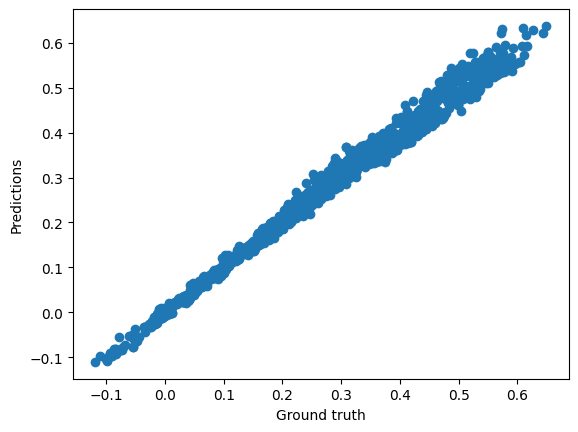

In [15]:
# The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]} -> {X_test[idx, 3]}. CoM: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}.')

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_feet_sim[:, 0:1], # Vref-1
               X_feet_sim[:, 1:2], # Vref
               X_feet_sim[:, 2:3], # Act-1
               X_feet_sim[:, 5:6], # Act
               X_feet_sim[:, 8:10], # FL position
               X_feet_sim[:, 11:13], # FR position
               X_feet_sim[:, 14:16], # RL position
               X_feet_sim[:, 17:19])) # RR position

# Labels
Y = np.array([Y_feet_sim[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_y = find_best_model(X, Y, runs=5000)

R2:  -91.65037398854383
RMSE:  0.02062222041696288
The lowest error is:  8.828053864456302e-06
The highest error is:  0.0668730044191059
The avg. error is:  0.017076102251916248


In [17]:
model_fl_relative_support_y.coef_

array([[ 0.07292048,  0.00122696, -0.00972269, -0.07540138,  0.055338  ,
        -0.00063982,  0.05034544,  0.00198942, -0.0410162 , -0.14807041,
        -0.04678586,  0.14940953]])

In [18]:
model_fl_relative_support_y.intercept_

array([-0.00957753])

Text(0, 0.5, 'Predictions')

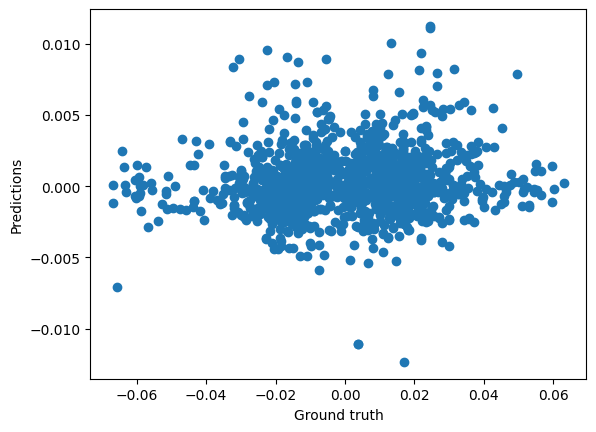

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')